# Main

In [1]:
from utils import *
import json

c:\Users\julian.quintero\FCPDIHC\PDIHC\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
alpha = 0.05

# Componente Proporcional y Gradiente (P)
T_burnin =120 # número de pasos iniciales antes de considerar ajustes proporcionales dinámicos (P) o el modelo derivativo (D).
lr = 0.02 #  tasa de aprendizaje en el componente proporcional, modulando la sensibilidad del modelo a los errores.

# Componente Integral (I)
Csat = 2.5 # Escala la saturación en el componente integral, ajustando su contribución al cuantil.
KI = 1.0 # Modula la sensibilidad del término integral a la acumulación de errores.

# Componente Derivativo (D)
ahead = 1 # Número de pasos hacia adelante  utilizada por el modelo derivativo,
seasonal_period = 7 # Periodo de la estacionalidad a modelar


n_series=10
n_points=365*3
noise_std=5
fore_std=10

In [3]:
# Definir períodos de alta incertidumbre (promociones, rebajas, etc.)
promo_periods = [("2023-11-20", "2023-11-27"), ("2024-11-25", "2024-12-02")]

df = generar_datos(n_series=n_series, n_points=n_points, seed=123, start_date="2023-01-01",noise_std=noise_std, fore_std=fore_std, promo_periods=promo_periods)
df = assign_data_sets(df, date_col="FECHA", future_col="FUTURE", calib_ratio=0.4)
print(df.to_string())

            KEY      FECHA           Y     YHATFIN  FUTURE  YHAT_L  YHAT_U    X          SET
0       SERIE_1 2023-01-01  108.563521   94.366306       0     NaN     NaN  0.0        TRAIN
1       SERIE_9 2023-01-01  105.565817   98.133771       0     NaN     NaN  0.0        TRAIN
2       SERIE_8 2023-01-01  101.922164  106.750353       0     NaN     NaN  0.0        TRAIN
3       SERIE_7 2023-01-01   92.050906  104.477617       0     NaN     NaN  0.0        TRAIN
4       SERIE_6 2023-01-01  104.582859  101.966221       0     NaN     NaN  0.0        TRAIN
5       SERIE_5 2023-01-01   95.625864   97.876139       0     NaN     NaN  0.0        TRAIN
6       SERIE_4 2023-01-01   94.823373   97.255630       0     NaN     NaN  0.0        TRAIN
7       SERIE_3 2023-01-01  104.943347  103.890474       0     NaN     NaN  0.0        TRAIN
8       SERIE_2 2023-01-01   97.833321  110.879370       0     NaN     NaN  0.0        TRAIN
9      SERIE_10 2023-01-01  110.982915  109.743545       0     NaN    

In [4]:
df_pdi, logs = apply_pdi_with_calibration_with_diagnostics(
    df=df,
    key_col="KEY",
    date_col="FECHA",
    value_col="Y",
    pred_col="YHATFIN",
    lower_col="YHAT_L",
    upper_col="YHAT_U",
    alpha=alpha,
    lr=lr,
    T_burnin=T_burnin,
    Csat=Csat,
    KI=KI,
    ahead=ahead,
    seasonal_period=seasonal_period,
    set_col="SET",
    # smooth_method ='last'
)

100%|██████████| 10/10 [00:22<00:00,  2.27s/it]


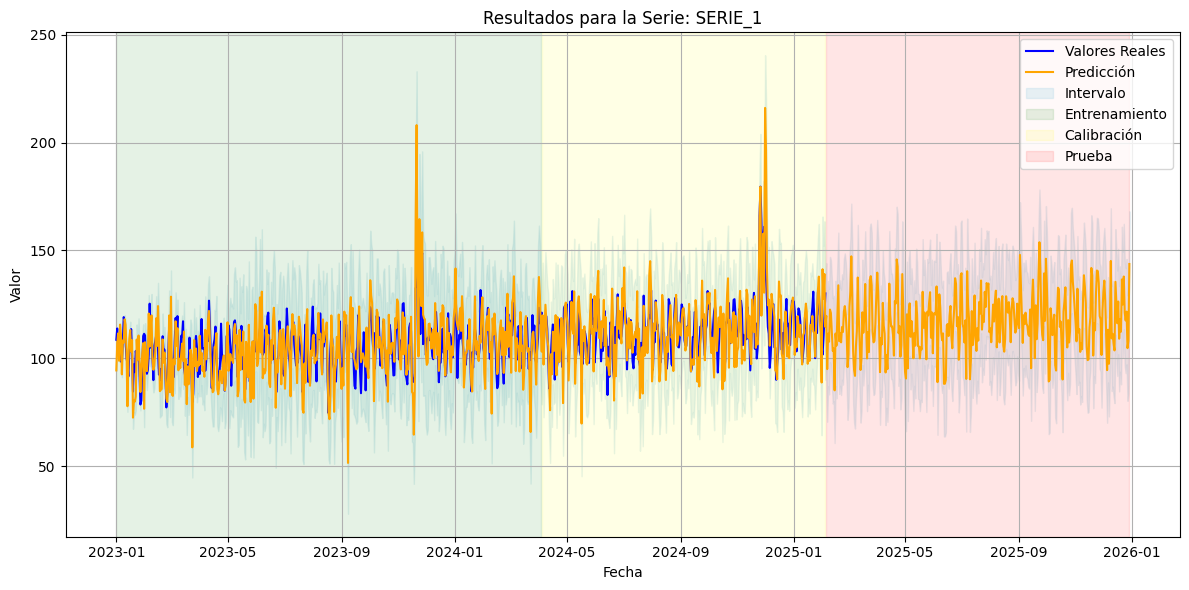

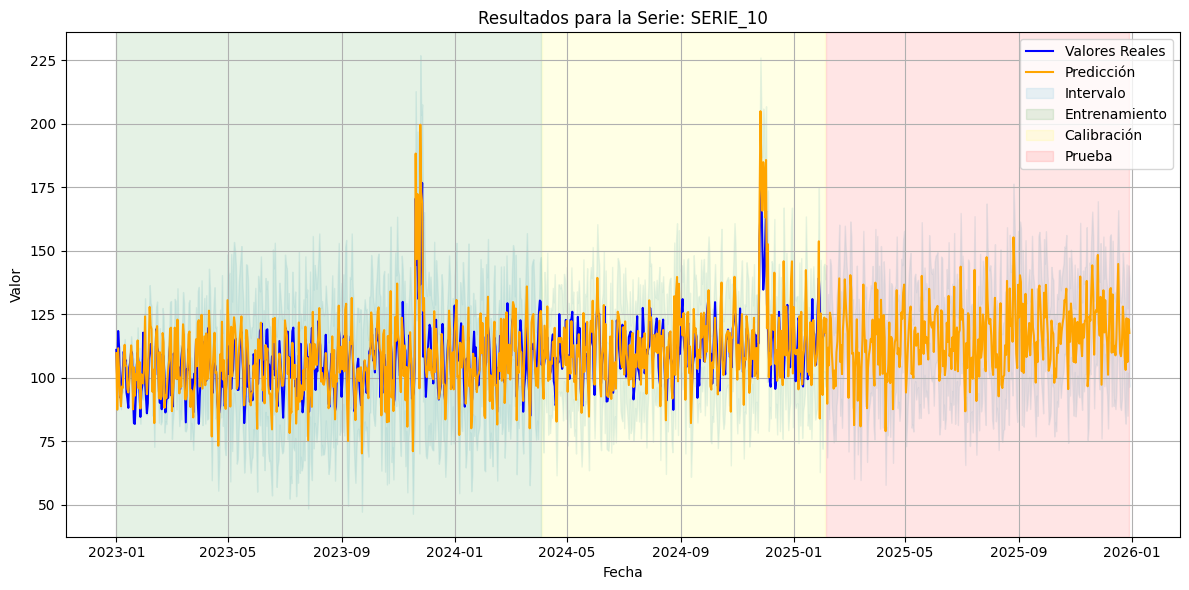

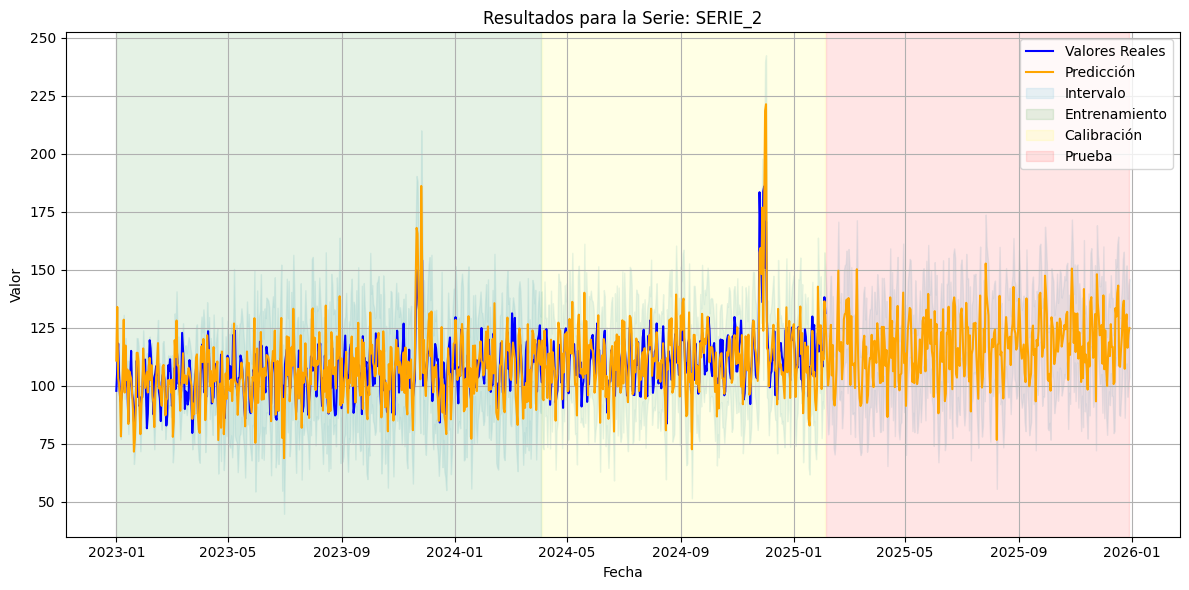

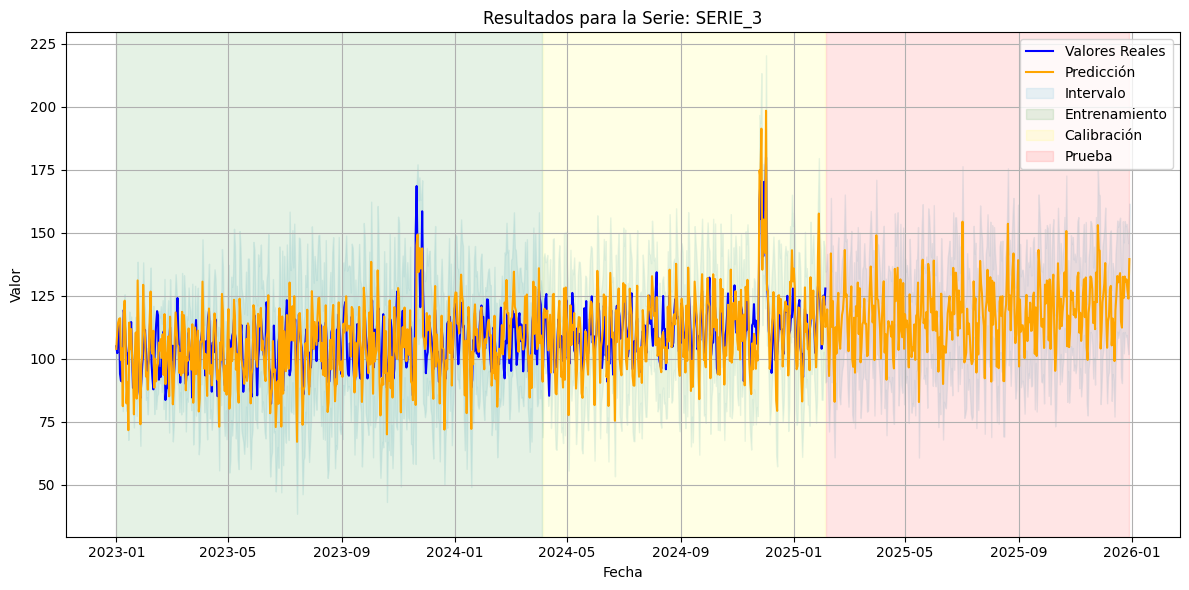

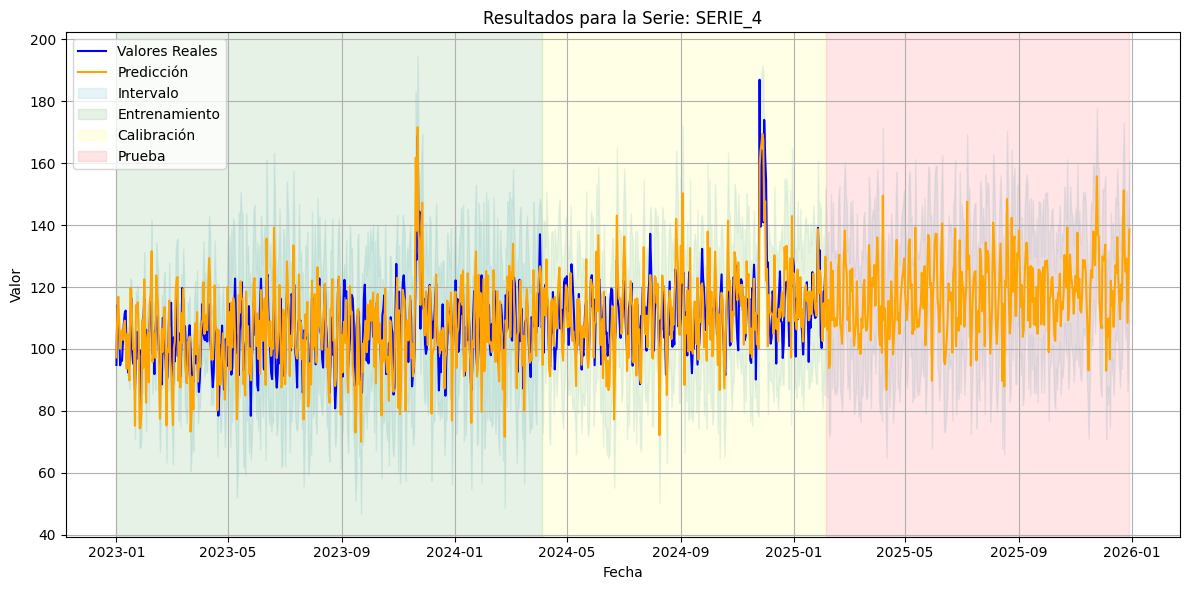

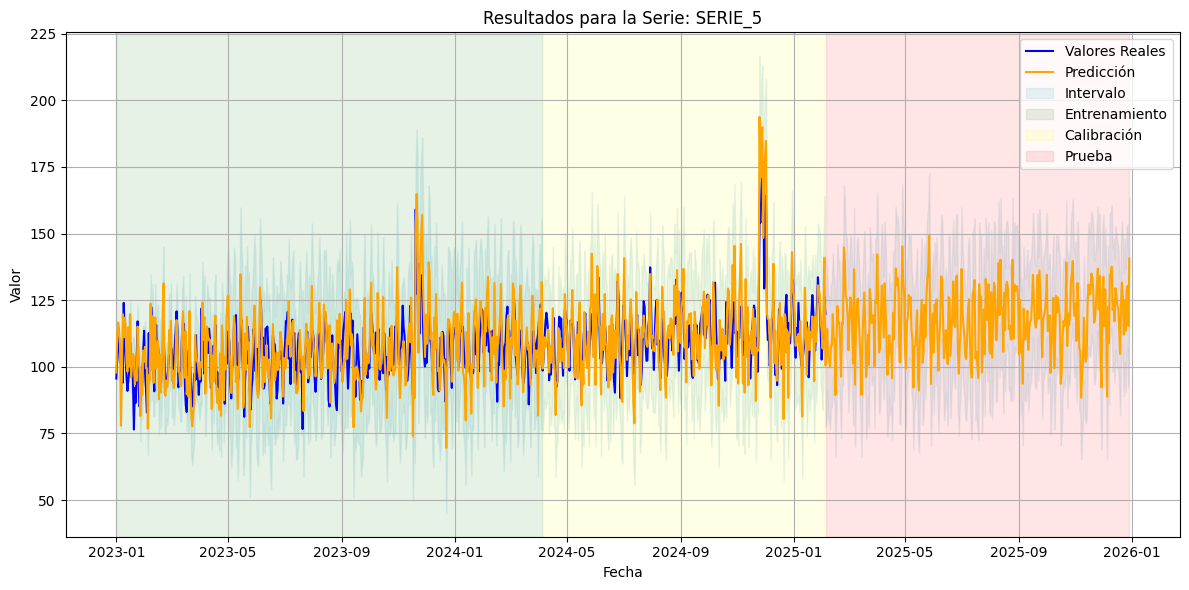

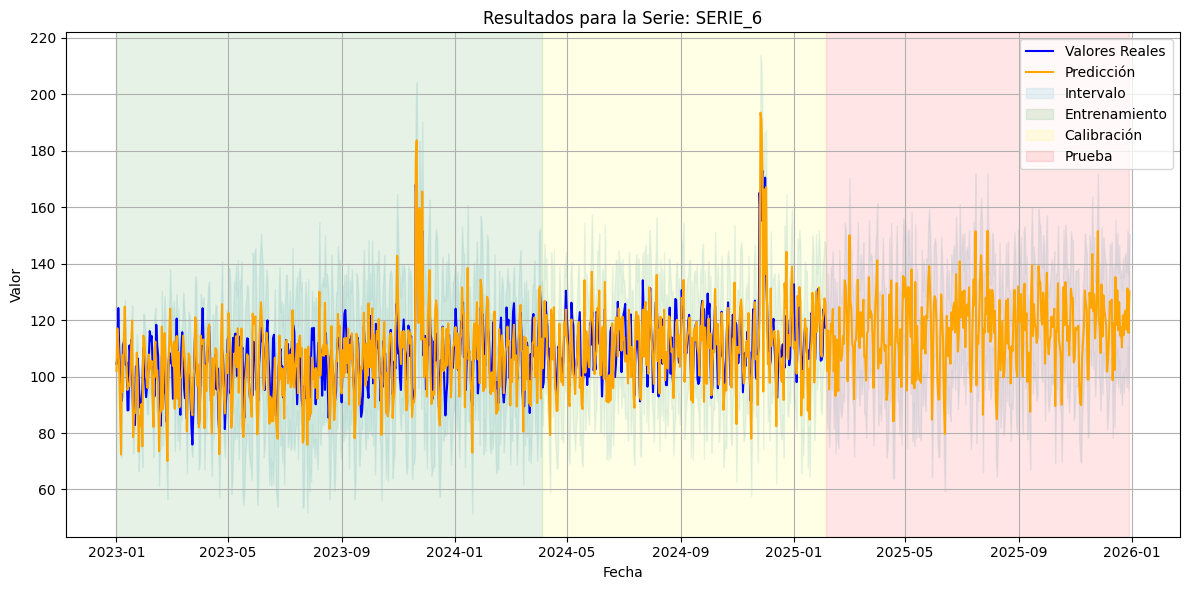

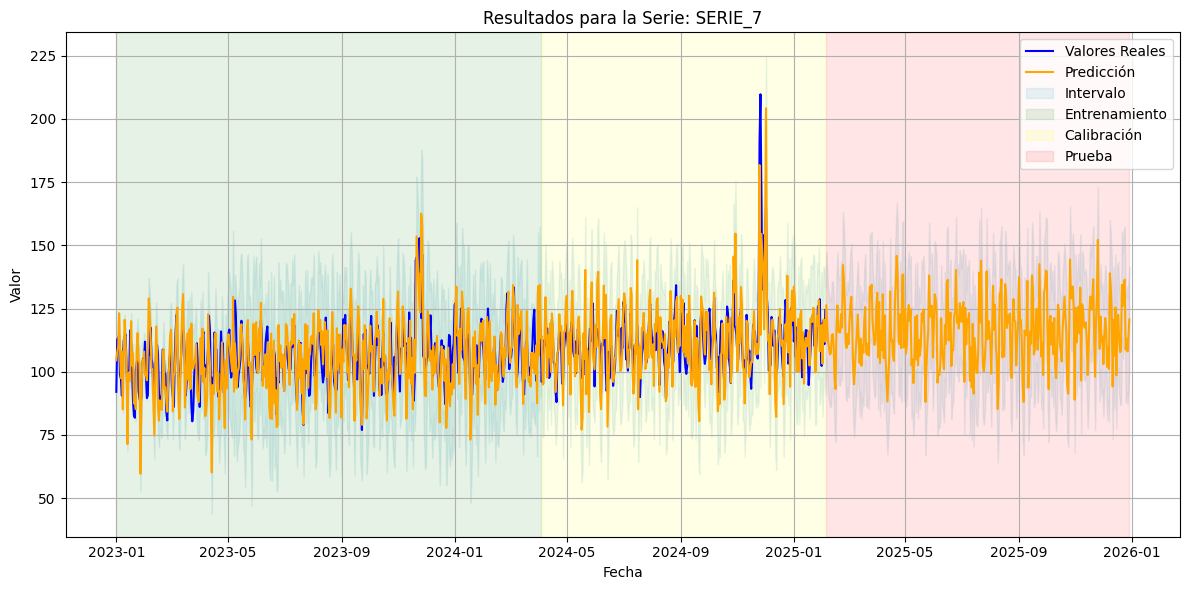

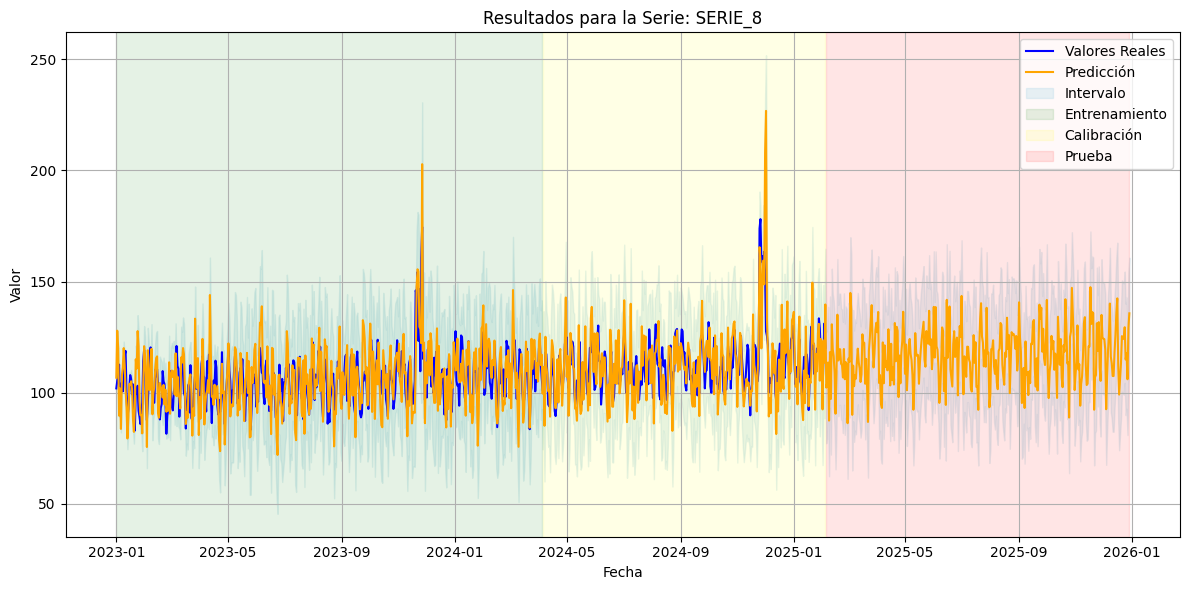

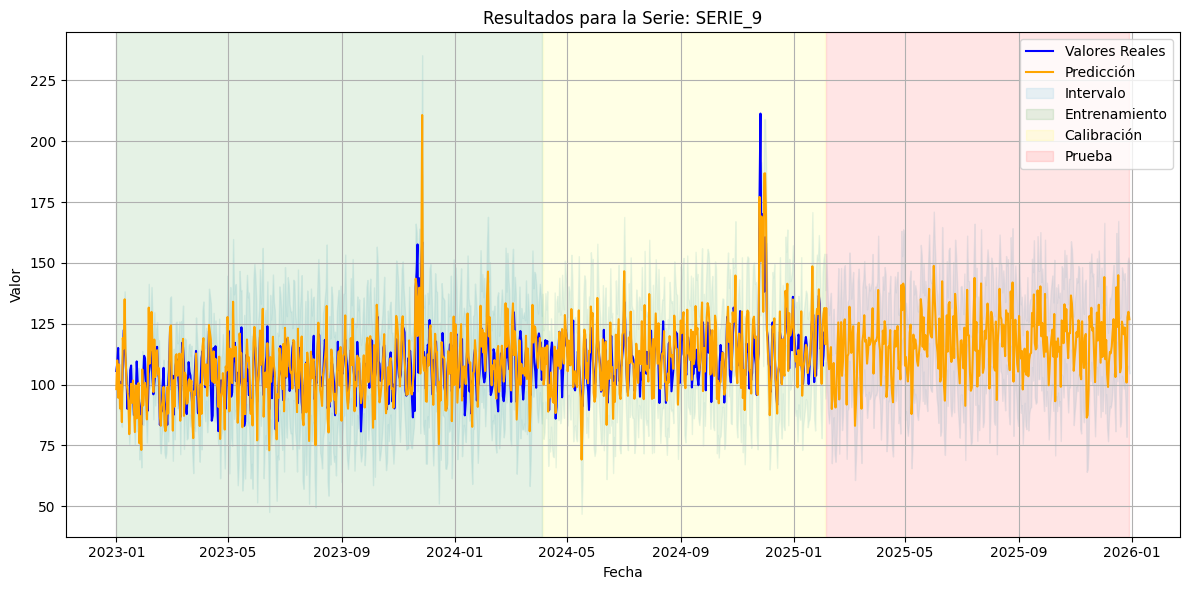

In [5]:
unique_keys = df_pdi['KEY'].unique()

for key in unique_keys:
    plot_series_results_with_sets(df_pdi, key=key)

In [6]:
# plot_logs(logs)

In [7]:
# Dividir el DataFrame en TRAIN, CALIBRATION y TEST
train_df = df_pdi[df_pdi["SET"] == "TRAIN"]
calib_df = df_pdi[df_pdi["SET"] == "CALIBRATION"]
test_df = df_pdi[df_pdi["SET"] == "TEST"]

# Calcular métricas por serie (KEY) para el conjunto de calibración
calib_metrics_by_key = calculate_metrics(
    calib_df,
    value_col="Y",
    lower_col="YHAT_L",
    upper_col="YHAT_U",
    alpha=alpha,
    condition_col="KEY"
)

# Mostrar resultados
print("Métricas por KEY (Calibración):")
print(calib_metrics_by_key)


Métricas por KEY (Calibración):
      Group  Marginal Coverage  Coverage Deviation  Average Region Size  \
0   SERIE_1           0.941368           -0.008632            48.833161   
1  SERIE_10           0.934853           -0.015147            42.252674   
2   SERIE_2           0.938111           -0.011889            42.201841   
3   SERIE_3           0.947712           -0.002288            44.057072   
4   SERIE_4           0.941176           -0.008824            44.037464   
5   SERIE_5           0.964052            0.014052            46.297943   
6   SERIE_6           0.911765           -0.038235            40.708510   
7   SERIE_7           0.938111           -0.011889            41.910199   
8   SERIE_8           0.964052            0.014052            50.090605   
9   SERIE_9           0.944444           -0.005556            44.558659   

   Winkler Score  
0      69.901731  
1      65.138259  
2      66.771931  
3      53.645405  
4      54.131089  
5      55.656457  
6      68

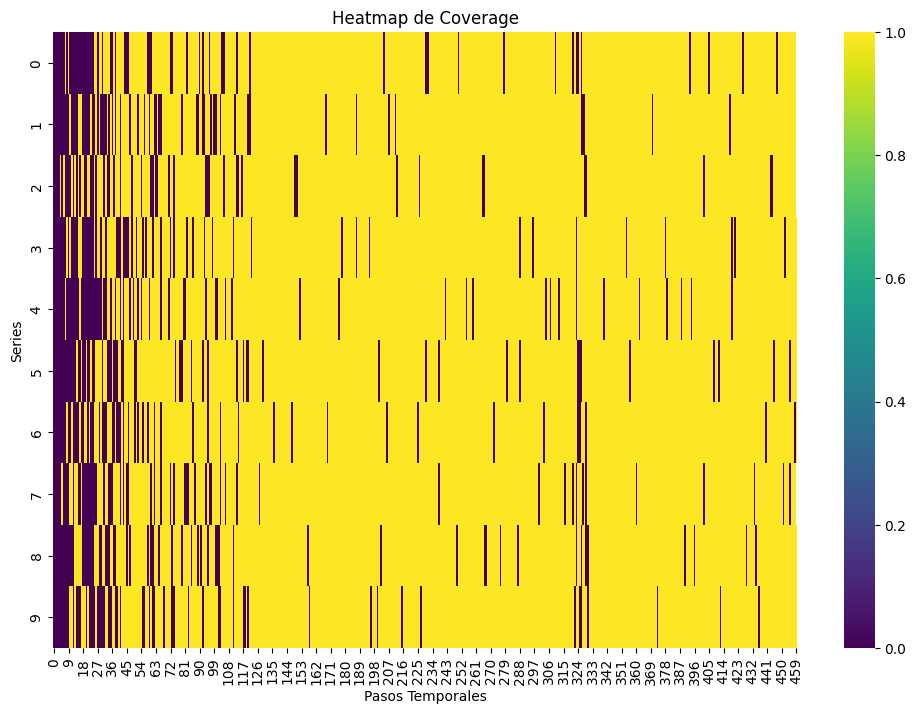

In [8]:
plot_heatmap(logs, component="coverage")

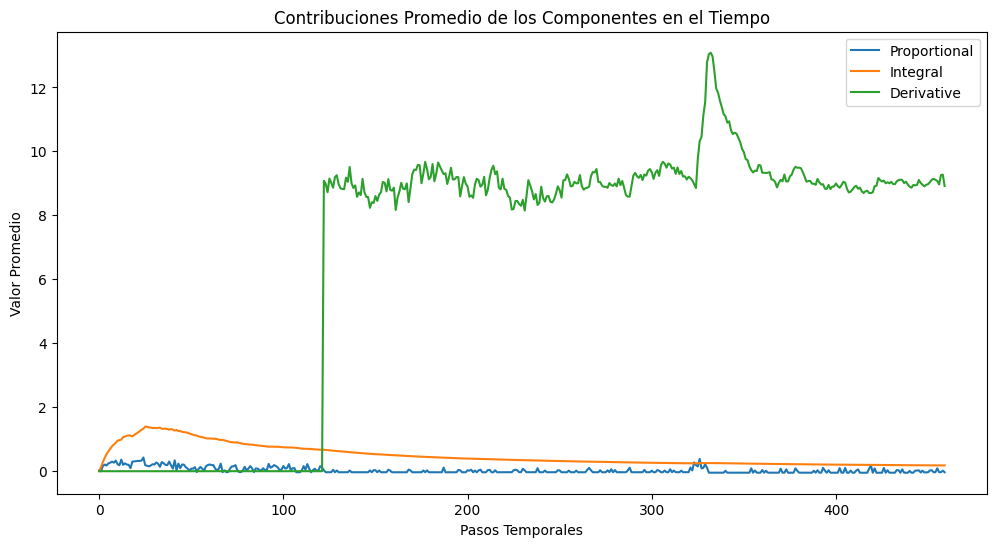

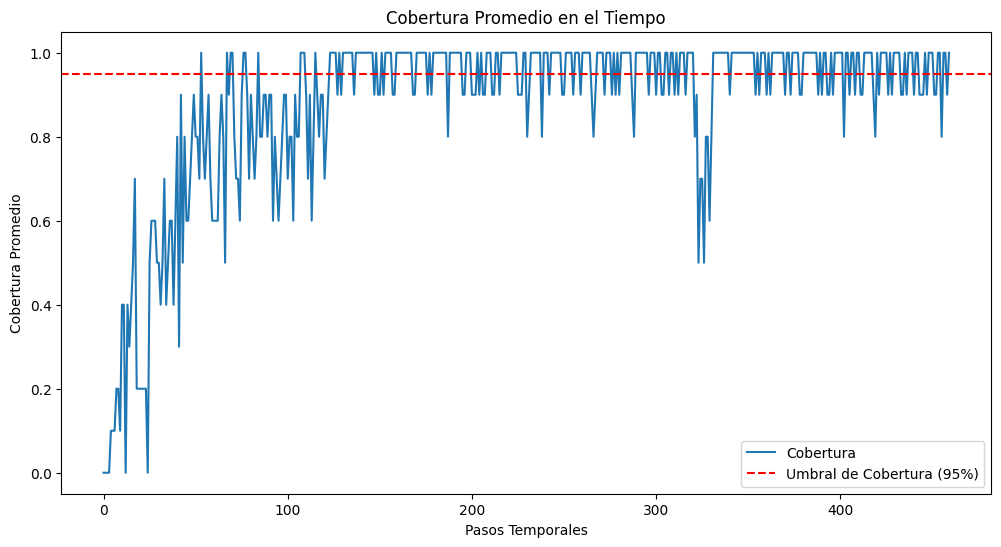

In [9]:
plot_logs_agg(aggregate_logs_average(logs))

In [10]:
calib_metrics = calculate_metrics(
    calib_df,
    value_col="Y",
    lower_col="YHAT_L",
    upper_col="YHAT_U",
    alpha=alpha
)
calib_metrics

Group  Marginal Coverage  Coverage Deviation  Average Region Size  \
0  Global           0.942559           -0.007441            44.493905   

   Winkler Score  
0      62.404684

In [11]:
calib_df

KEY      FECHA           Y     YHATFIN  FUTURE      YHAT_L  \
4597  SERIE_1 2024-04-04  121.160434  103.066731       0   78.650151   
4601  SERIE_1 2024-04-05  110.846534  119.888042       0   95.471461   
4611  SERIE_1 2024-04-06  104.566781   97.087897       0   72.671316   
4627  SERIE_1 2024-04-07  113.320735  113.326667       0   88.910087   
4636  SERIE_1 2024-04-08  119.926532  124.803510       0  100.386929   
...       ...        ...         ...         ...     ...         ...   
7614  SERIE_9 2025-01-31  116.451567  100.282089       0   78.002759   
7627  SERIE_9 2025-02-01  107.575933  123.458888       0  101.179558   
7636  SERIE_9 2025-02-02  111.784691  129.130233       0  106.850904   
7646  SERIE_9 2025-02-03  121.631304  131.475281       0  109.195951   
7650  SERIE_9 2025-02-04  118.096321  116.547659       0   94.268329   

          YHAT_U    X          SET  
4597  127.483312  0.0  CALIBRATION  
4601  144.304623  0.0  CALIBRATION  
4611  121.504477  0.0  CALIBRATION  
4627  137.743248  0.0  CALIBRATION  
4636  149.220090  0.0  CALIBRATION  
...          ...  ...          ...  
7614  122.561418  0.0  CALIBRATION  
7627  145.738217  0.0  CALIBRATION  
7636  151.409563  0.0  CALIBRATION  
7646  153.754610  0.0  CALIBRATION  
7650  138.826988  0.0  CALIBRATION  

[3064 rows x 9 columns]

In [12]:
calib_df

KEY      FECHA           Y     YHATFIN  FUTURE      YHAT_L  \
4597  SERIE_1 2024-04-04  121.160434  103.066731       0   78.650151   
4601  SERIE_1 2024-04-05  110.846534  119.888042       0   95.471461   
4611  SERIE_1 2024-04-06  104.566781   97.087897       0   72.671316   
4627  SERIE_1 2024-04-07  113.320735  113.326667       0   88.910087   
4636  SERIE_1 2024-04-08  119.926532  124.803510       0  100.386929   
...       ...        ...         ...         ...     ...         ...   
7614  SERIE_9 2025-01-31  116.451567  100.282089       0   78.002759   
7627  SERIE_9 2025-02-01  107.575933  123.458888       0  101.179558   
7636  SERIE_9 2025-02-02  111.784691  129.130233       0  106.850904   
7646  SERIE_9 2025-02-03  121.631304  131.475281       0  109.195951   
7650  SERIE_9 2025-02-04  118.096321  116.547659       0   94.268329   

          YHAT_U    X          SET  
4597  127.483312  0.0  CALIBRATION  
4601  144.304623  0.0  CALIBRATION  
4611  121.504477  0.0  CALIBRATION  
4627  137.743248  0.0  CALIBRATION  
4636  149.220090  0.0  CALIBRATION  
...          ...  ...          ...  
7614  122.561418  0.0  CALIBRATION  
7627  145.738217  0.0  CALIBRATION  
7636  151.409563  0.0  CALIBRATION  
7646  153.754610  0.0  CALIBRATION  
7650  138.826988  0.0  CALIBRATION  

[3064 rows x 9 columns]

In [13]:
date_col = "FECHA"
key_col = "KEY"
set_col="SET"
value_col="Y"
pred_col="YHATFIN" 
lower_col="YHAT_L"
upper_col="YHAT_U"
calib_df = df_pdi[df_pdi["SET"] == "CALIBRATION"]
unique_keys = calib_df['KEY'].unique()
unique_keys

array(['SERIE_1', 'SERIE_10', 'SERIE_2', 'SERIE_3', 'SERIE_4', 'SERIE_5',
       'SERIE_6', 'SERIE_7', 'SERIE_8', 'SERIE_9'], dtype=object)

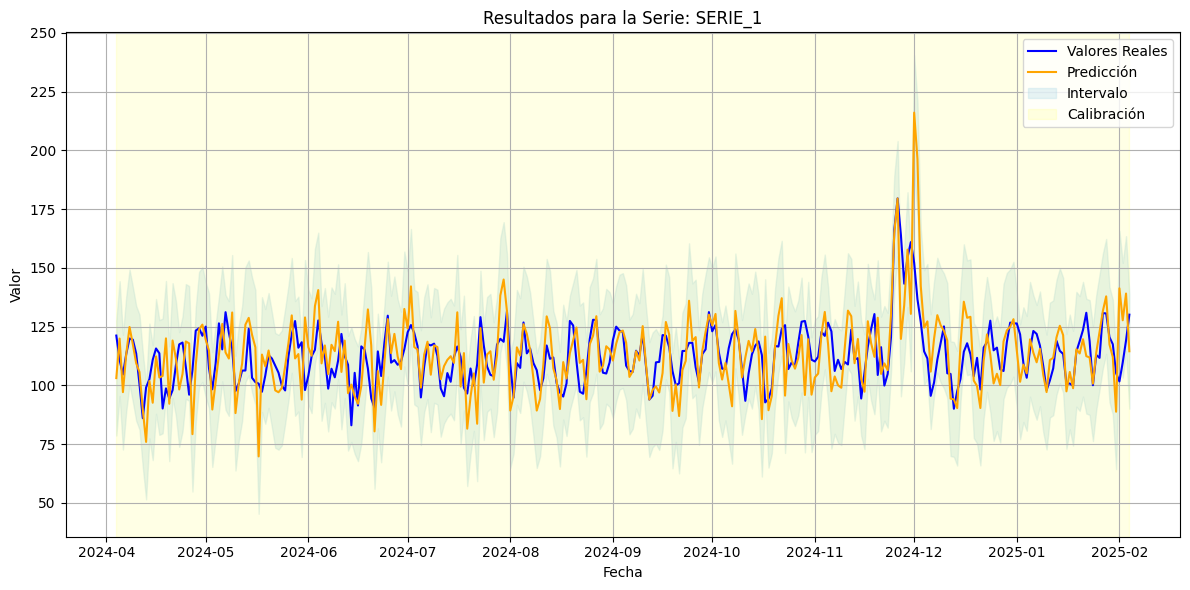

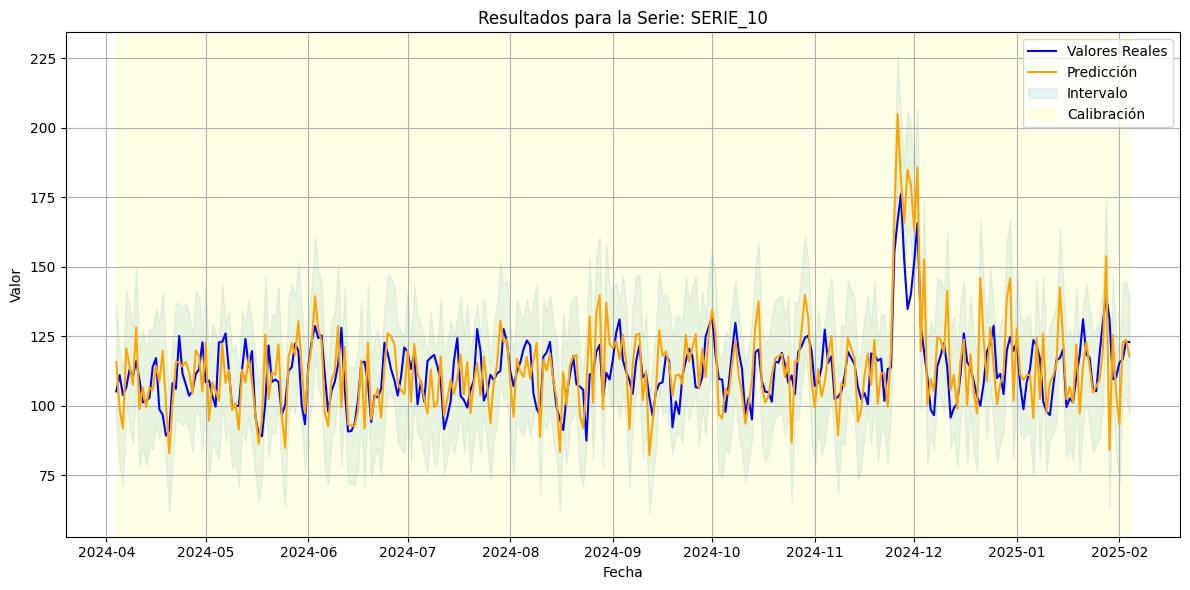

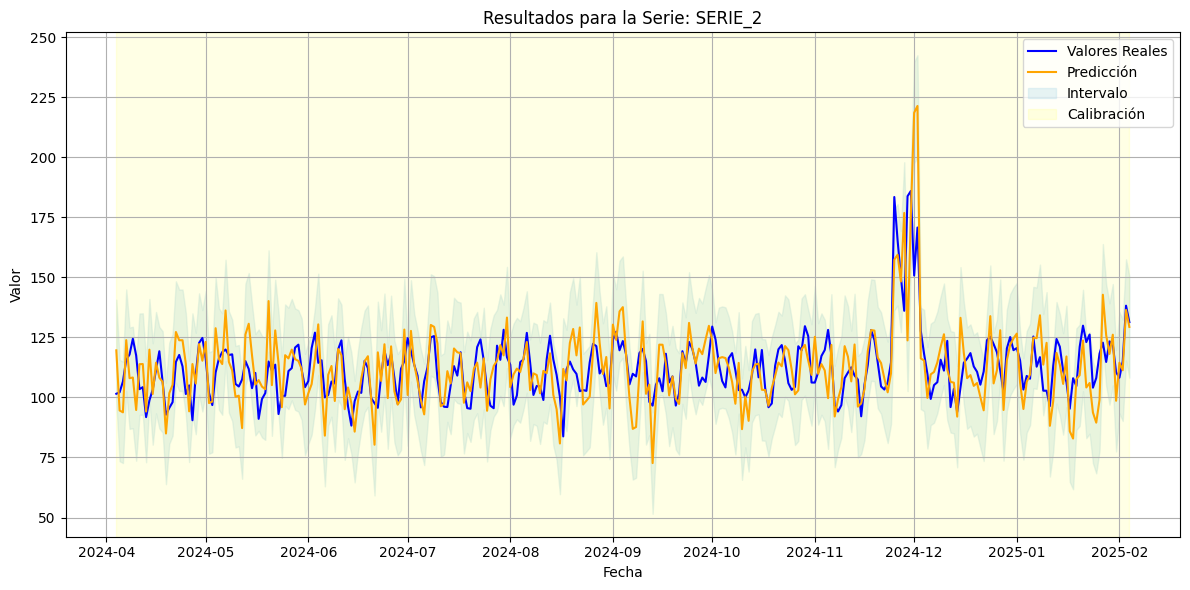

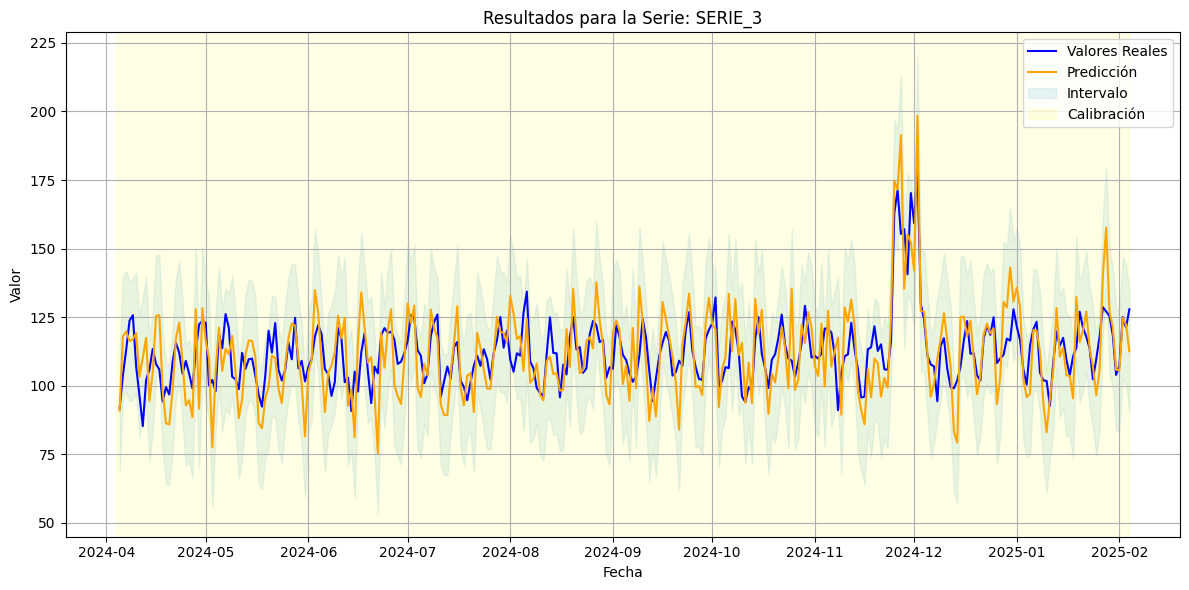

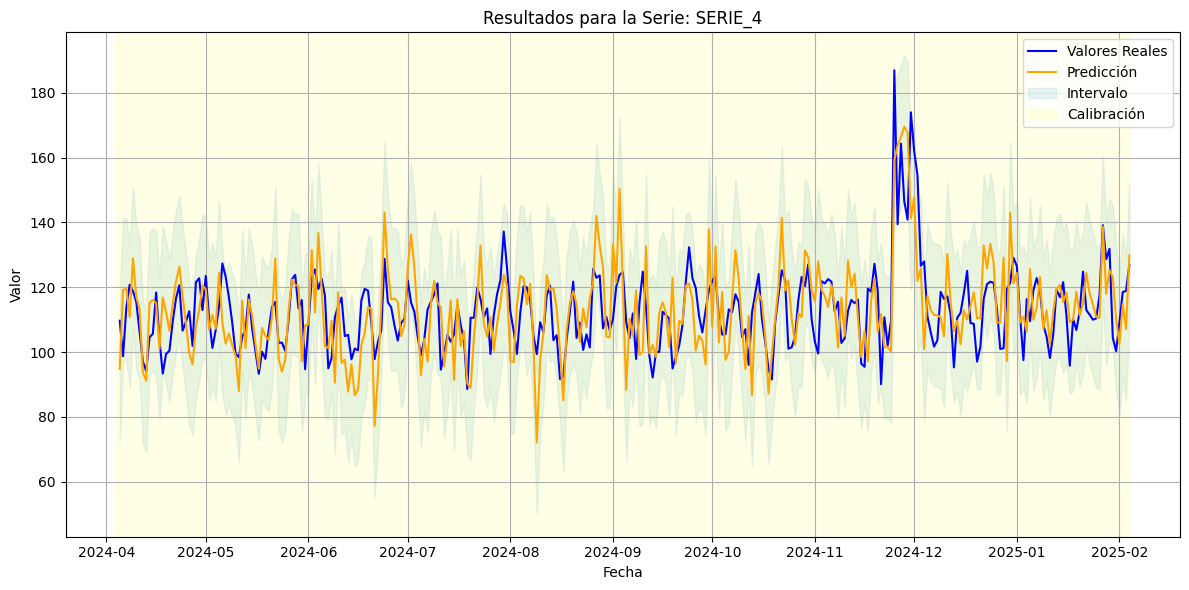

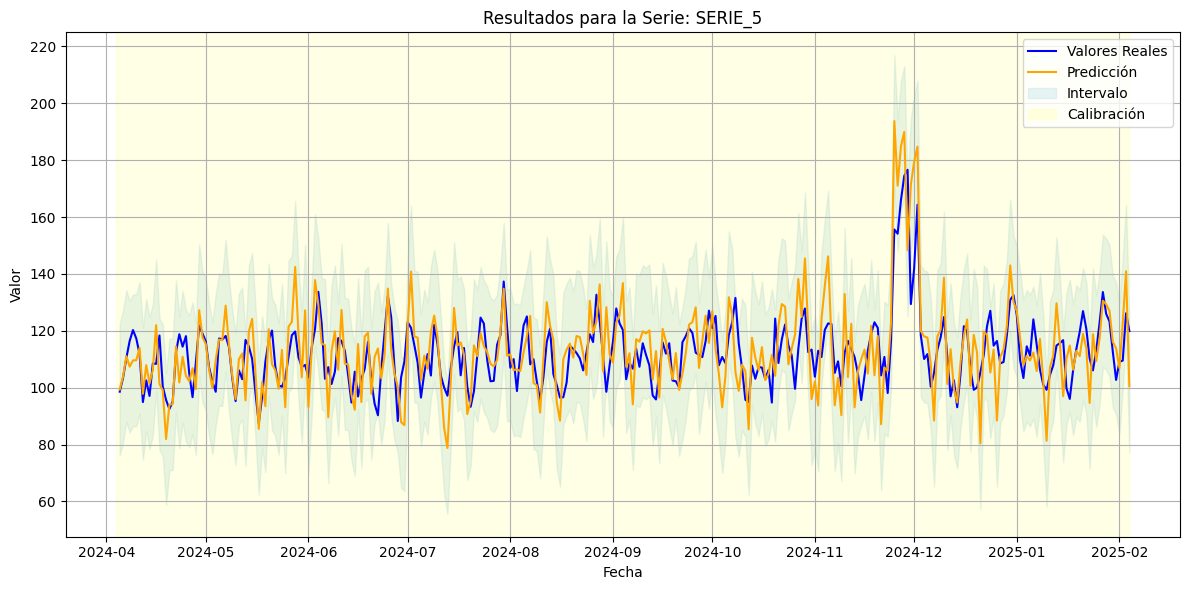

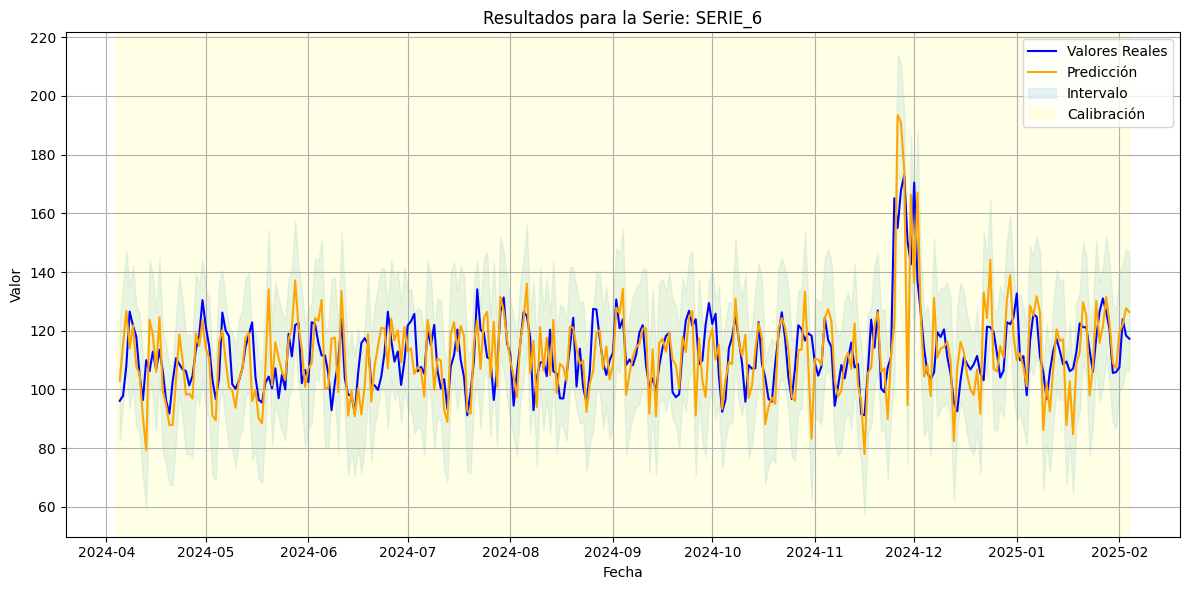

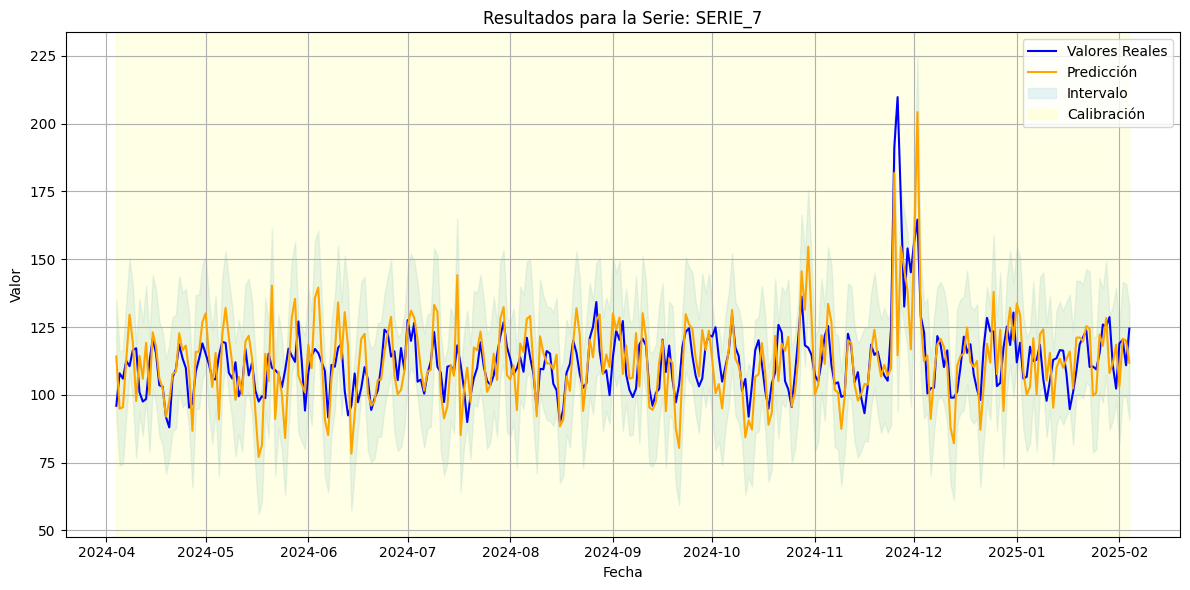

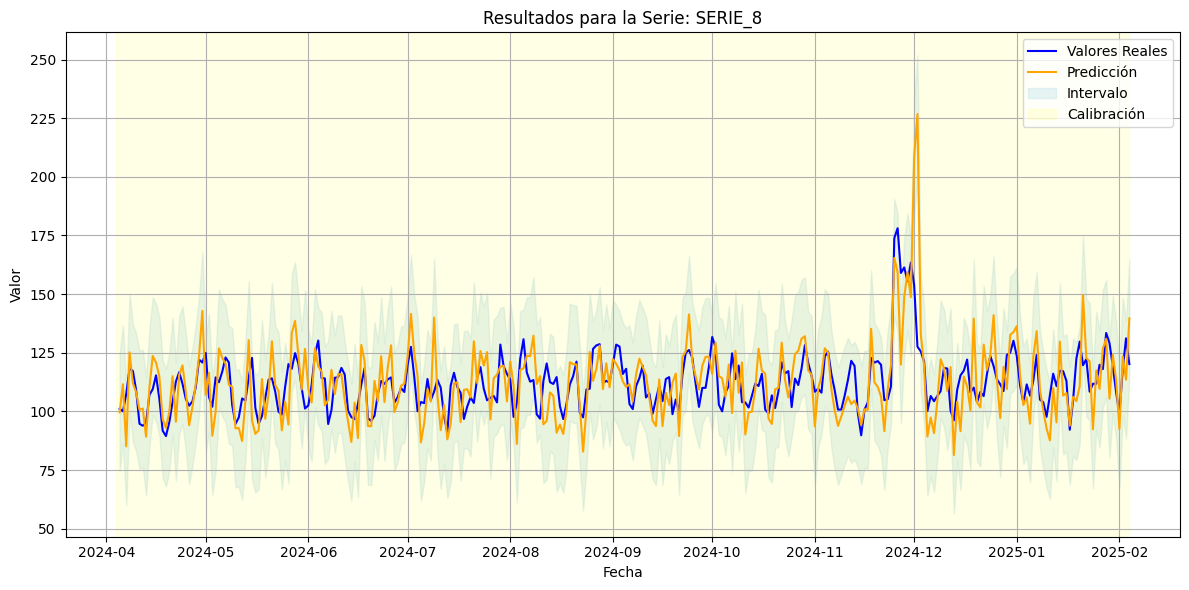

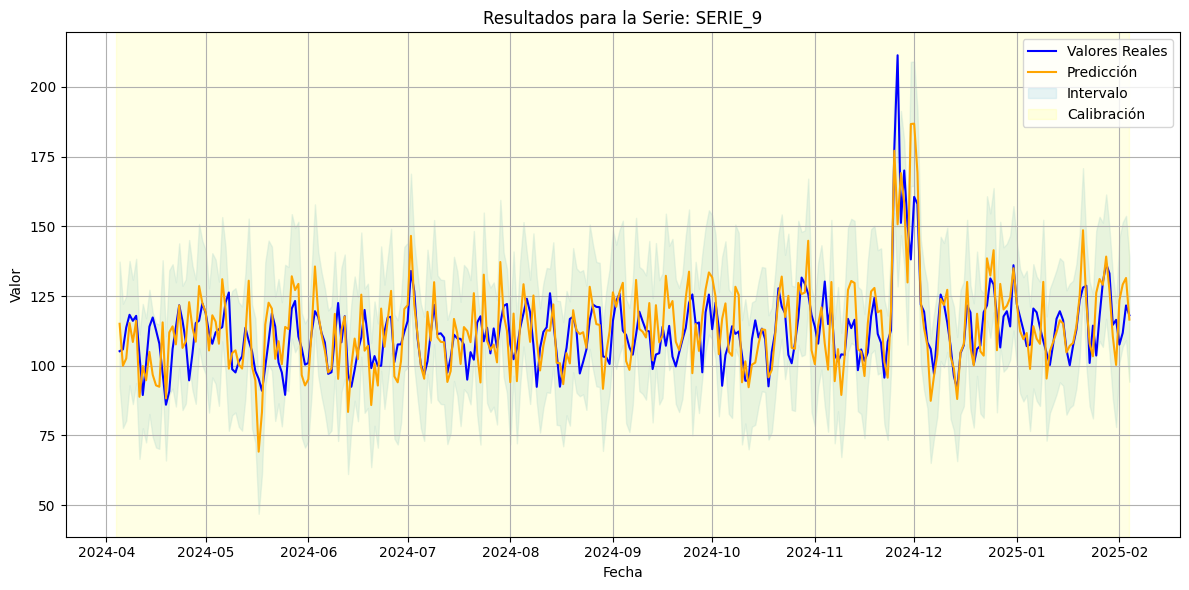

In [14]:


for key in unique_keys:
    series_df = calib_df[calib_df[key_col] == key].sort_values(by=date_col)
    plt.figure(figsize=(12, 6))
    plt.plot(series_df[date_col], series_df[value_col], "-", label="Valores Reales", color="blue")
    plt.plot(series_df[date_col], series_df[pred_col], "-", label="Predicción", color="orange")
    plt.fill_between(series_df[date_col], series_df[lower_col], series_df[upper_col], color="lightblue", alpha=0.3, label="Intervalo")
    plt.axvspan(calib_df[date_col].min(), calib_df[date_col].max(), color="yellow", alpha=0.1, label="Calibración")
    plt.title(f"Resultados para la Serie: {key}")
    plt.xlabel("Fecha")
    plt.ylabel("Valor")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()